# Training a RNN model using the basic negation data (version 1)


## Here we will use the RNN model to distinguish between to kind of sentences:

- 1) A, not A (contradiction)

- 2) not A, A (contradiction)

- 3) A, not B (non-contradiction)

- 4) not B, A (non-contradiction)



In [1]:
# all imports
import numpy as np
import pandas as pd
import torch
from torchtext import data
import torch.optim as optim
from sklearn import linear_model


import os
import inspect
import sys
import itertools

almost_current = os.path.abspath(inspect.getfile(inspect.currentframe()))
currentdir = os.path.dirname(almost_current)
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

from plots.functions  import plot_confusion_matrix, plot_histogram_from_labels
from text_processing.functions import simple_pre_process_text_df, simple_pre_process_text

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
train_data_path = os.path.join(parentdir,
                               "text_generator",
                                "b1_v1_train.csv")

test_data_path = os.path.join(parentdir,
                              "text_generator",
                              "b1_v1_test.csv")

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [3]:
train_data.head()

,sentence1,sentence2,label
0,Brooke is not helpful,Brooke is helpful,1
1,Boo is not clever,Boo is clever,1
2,Doe is not poor,Doe is poor,1
3,Hodgson is ambitious,Hodgson is not ambitious,1
4,Hobbes is proud,Marston is not easy,0


In [4]:
test_data.head()

,sentence1,sentence2,label
0,Oakley is brave,Oakley is not brave,1
1,Jean is not alive,Jean is alive,1
2,Starlit is proud,Starlit is not proud,1
3,Temple is not delightful,Westcott is wrong,0
4,Jazz is jolly,Jazz is not jolly,1


## Putting the sentences together

In [5]:
train_data["text"] = train_data["sentence1"]  + ", " + train_data["sentence2"]
test_data["text"] = test_data["sentence1"]  + ", " + test_data["sentence2"]
train_data.drop(["sentence1", "sentence2"], axis=1, inplace=True)
test_data.drop(["sentence1", "sentence2"], axis=1, inplace=True)
train_data = train_data[["text", "label"]]
test_data = test_data[["text", "label"]] 

In [6]:
train_data.head()

,text,label
0,"Brooke is not helpful, Brooke is helpful",1
1,"Boo is not clever, Boo is clever",1
2,"Doe is not poor, Doe is poor",1
3,"Hodgson is ambitious, Hodgson is not ambitious",1
4,"Hobbes is proud, Marston is not easy",0


In [7]:
test_data.head()

,text,label
0,"Oakley is brave, Oakley is not brave",1
1,"Jean is not alive, Jean is alive",1
2,"Starlit is proud, Starlit is not proud",1
3,"Temple is not delightful, Westcott is wrong",0
4,"Jazz is jolly, Jazz is not jolly",1


In [8]:
labels_legend = ['no', 'yes']
anwser2int = {'no':0, 'yes':1}
int2anwser = {i[1]: i[0] for i in anwser2int.items()}
train_labels = [int2anwser[i] for i in train_data["label"].values]
test_labels = [int2anwser[i] for i in train_data["label"].values]

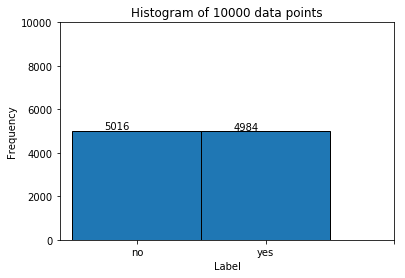

In [9]:
plot_histogram_from_labels(train_labels, labels_legend, "train data")

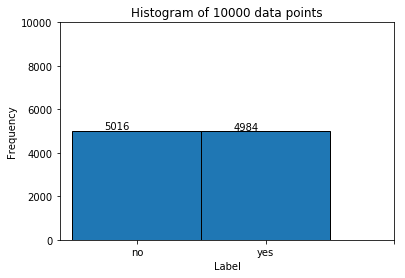

In [10]:
plot_histogram_from_labels(test_labels, labels_legend, "train data")

### Applying preprocessing function

In [11]:
print("\n=== BEFORE ===\n")

print(train_data["text"].values[2])
print()
print(train_data["text"].values[3])
print()
print(train_data["text"].values[4])


print("\n=== AFTER ===\n")
simple_pre_process_text_df(train_data)
simple_pre_process_text_df(test_data)
print(train_data["text"].values[2])
print()
print(train_data["text"].values[3])
print()
print(train_data["text"].values[4])


=== BEFORE ===

Doe is not poor,  Doe is poor

Hodgson is ambitious,  Hodgson is not ambitious

Hobbes is proud,  Marston is not easy

=== AFTER ===

doe is not poor doe is poor

hodgson is ambitious hodgson is not ambitious

hobbes is proud marston is not easy


## Saving the new version of the data in a csv

In [12]:
train_data_path = os.path.join(parentdir,
                               "text_generator",
                                "b1_v1_train_processed.csv")

test_data_path = os.path.join(parentdir,
                              "text_generator",
                              "b1_v1_test_processed.csv")


train_data.to_csv(train_data_path, header=False, index=False)
test_data.to_csv(test_data_path, header=False, index=False)

## Creating count vectors

In [13]:
train_text = list(train_data.text.values)
test_text = list(test_data.text.values)

train_labels = train_data.label.values
test_labels = test_data.label.values

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_text)
train_X = X.toarray()
test_X = vectorizer.transform(test_text).toarray()
test_x, test_y = test_X, test_labels
train_x, train_y = train_X, train_labels

## Without changing the size of the vector

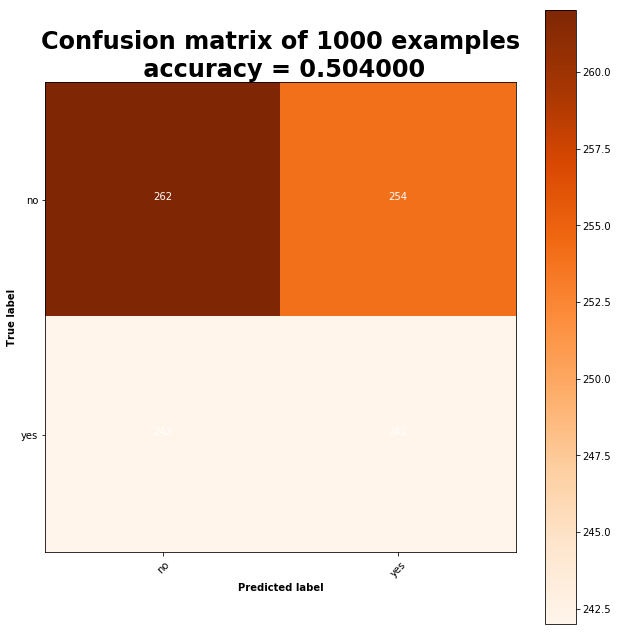

In [15]:
lr = linear_model.LogisticRegression()
lr.fit(train_x, train_y)
pred = lr.predict(test_x)


plot_confusion_matrix(truth=test_y,
                      predictions=pred,
                      save=False,
                      path="linear_model_v1.png",
                      classes=labels_legend)


## Adding score for each word depending on the classes

In [16]:
def transform_X(X):
    new_X = []
    vocab_size = X.shape[1]
    for x in X:
        car = np.concatenate([np.zeros((vocab_size,)), x])
        cdr = np.concatenate([x, np.zeros((vocab_size,))])
        new = np.stack([car,cdr])
        new_X.append(new)

    return np.stack(new_X)


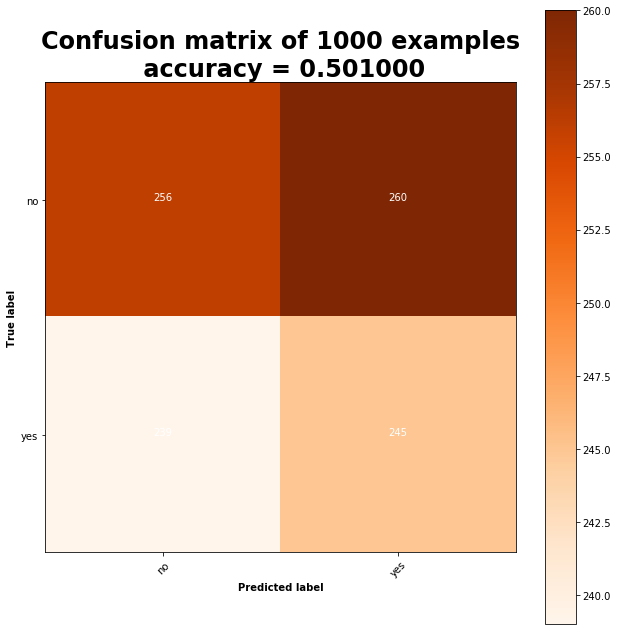

In [17]:
lr = linear_model.LogisticRegression()
train_x_t = transform_X(train_x)
train_x_t = train_x_t.reshape((train_x_t.shape[0], -1))

lr.fit(train_x_t, train_y)

test_x_t = transform_X(test_x)
test_x_t = test_x_t.reshape((test_x_t.shape[0], -1))
pred = lr.predict(test_x_t)

plot_confusion_matrix(truth=test_y,
                      predictions=pred,
                      save=False,
                      path="linear_model_v1.png",
                      classes=labels_legend)

## Training in PyTorch

In [18]:
class RNNConfig(object):
    """
    Holds logistic regression model hyperparams.
    
    :param height: image height
    :type heights: int
    :param width: image width
    :type width: int
    :param channels: image channels
    :type channels: int
    :param batch_size: batch size for training
    :type batch_size: int
    :param epochs: number of epochs
    :type epochs: int
    :param save_step: when step % save_step == 0, the model
                      parameters are saved.
    :type save_step: int
    :param learning_rate: learning rate for the optimizer
    :type learning_rate: float
    :param momentum: momentum param
    :type momentum: float
    """
    def __init__(self,
                 vocab_size=25000,
                 batch_size=32,
                 embedding_dim=100,
                 rnn_dim=100,
                 output_dim=2,
                 epochs=10,
                 learning_rate=0.501,
                 momentum=0.1):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.rnn_dim = rnn_dim
        self.output_dim = output_dim
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        

    def __str__(self):
        """
        Get all attributs values.
        :return: all hyperparams as a string
        :rtype: str
        """
        status = "vocab_size = {}\n".format(self.vocab_size)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "embedding_dim = {}\n".format(self.embedding_dim)
        status += "rnn_dim = {}\n".format(self.rnn_dim)
        status += "output_dim = {}\n".format(self.output_dim)
        status += "epochs = {}\n".format(self.epochs)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        return status

In [19]:
from torch.utils.data import TensorDataset

train_x_t = transform_X(train_x)
train_x_t = train_x_t.reshape((train_x_t.shape[0], -1))

test_x_t = transform_X(test_x)
test_x_t = test_x_t.reshape((test_x_t.shape[0], -1))

valid_x_t, valid_y = train_x_t[0:1000], train_y[0:1000]
train_x_t, train_y = train_x_t[1000:], train_y[1000:]


In [20]:

train_dataset = TensorDataset(torch.from_numpy(train_x_t),
                              torch.from_numpy(train_y))
valid_dataset = TensorDataset(torch.from_numpy(valid_x_t),
                              torch.from_numpy(valid_y))
test_dataset = TensorDataset(torch.from_numpy(test_x_t),
                             torch.from_numpy(test_y))

In [21]:
from torch.utils.data import DataLoader


class DataHolderGentle():
    """
    Class to store all data using the GentleLoader.

    :param config: hyper params configuration
    :type config: LRConfig or DFNConfig
    :param train_dataset: dataset of training data
    :type train_dataset: torch.utils.data.dataset.TensorDataset
    :param test_dataset: dataset of test data
    :type test_dataset: torch.utils.data.dataset.TensorDataset
    :param valid_dataset: dataset of valid data
    :type valid_dataset: torch.utils.data.dataset.TensorDataset
    :param batch_size: batch size for training
    :type test_batch: batch size for the testing data
    :param test_batch: int
    """
    def __init__(self,
                 config,
                 train_dataset,
                 valid_dataset,
                 test_dataset,
                 test_batch=1000):
        batch_size = config.batch_size
        self.train_iter = DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.valid_iter = DataLoader(dataset=valid_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.test_iter = DataLoader(dataset=test_dataset,
                                        batch_size=test_batch,
                                        shuffle=True)


In [22]:
lr_config = RNNConfig(embedding_dim=2714*2)
b1data = DataHolderGentle(lr_config, train_dataset, valid_dataset, test_dataset)

In [23]:
batch_X, batch_y = next(iter(b1data.train_iter))
batch_X = batch_X
print("exemplo de batch de treinamento\n")
print("batch_X")
print(batch_X)
print()
print("batch_X.type =", batch_X.type())
print()
print("batch_X.shape =", batch_X.shape)
print()
print("\nbatch_y")
print(batch_y)
print()
print("batch_y.type =", batch_y.type())
print()
print("batch_y.shape =", batch_y.shape)
print()

exemplo de batch de treinamento

batch_X
tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]], dtype=torch.float64)

batch_X.type = torch.DoubleTensor

batch_X.shape = torch.Size([32, 5428])


batch_y
tensor([ 1,  0,  0,  0,  0,  0,  1,  1,  1,  0,  1,  1,  0,  0,
         0,  1,  0,  1,  0,  0,  1,  1,  1,  0,  0,  0,  1,  0,
         1,  1,  1,  1])

batch_y.type = torch.LongTensor

batch_y.shape = torch.Size([32])



In [24]:
import torch.nn as nn
class LR(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.fc = nn.Linear(config.embedding_dim, config.output_dim)
        
    def forward(self, x):
        """
        Apply the model to the input x
        
        :param x: indices of the sentence
        :type x: torch.Tensor(shape=[sent len, batch size]
                              dtype=torch.int64)
        """        
        out = self.fc(x)
        return out

    def predict(self, x):
        out = self.forward(x)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

    def evaluate_bach(self, batch):
        prediction = model.predict(batch)
        labels = batch.label.type('torch.LongTensor')
        correct = torch.sum(torch.eq(prediction, labels)).float()
        accuracy = float(correct/labels.shape[0])
        return accuracy, prediction, labels

In [25]:
test_bach = next(iter(b1data.test_iter))
test_in = test_bach[0]
test_in = test_in.type(torch.float32)

In [26]:
lr_config = RNNConfig(embedding_dim=2714*2)
model = LR(lr_config)
prediction = model.predict(test_in)
labels = test_bach[1].type('torch.LongTensor')
correct = torch.sum(torch.eq(prediction, labels)).float()
accuracy = float(correct/labels.shape[0])
accuracy

0.5339999794960022

In [27]:
def train_model_img_classification(model,
                                   config,
                                   dataholder,
                                   model_path,
                                   verbose=True):
    """
    Train a model for image classification

    :param model: image classification model
    :type model: LogisticRegression or DFN
    :param config: image classification model
    :type config: LogisticRegression or DFN
    :param dataholder: data
    :type dataholder: DataHolder
    :param model_path: path to save model params
    :type model_path: str
    :param verbose: param to control print
    :type verbose: bool
    """
    train_loader = dataholder.train_iter
    valid_loader = dataholder.valid_iter

    best_valid_loss = float("inf")
    # YOUR CODE HERE:
    # You may find nn.CrossEntropyLoss and torch.optim.SGD useful here.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=config.learning_rate,
                                momentum=config.momentum)
    # END YOUR CODE
    train_loss = []
    valid_loss = []
    for epoch in range(config.epochs):
        for step, (images, labels) in enumerate(train_loader):
            # YOUR CODE HERE:
            # you should zero the model gradients
            # and define the loss function for the train data
            # loss = None
            model.zero_grad()
            images = images.type(torch.float32)
            outputs = model(images)
            loss = criterion(outputs, labels)
            # END YOUR CODE
            if step % 20 == 0:
                # YOUR CODE HERE:
                # you should define the loss function for the valid data
                # v_loss = None
                images, labels = next(iter(valid_loader))
                images = images.type(torch.float32)
                outputs = model(images)
                v_loss = criterion(outputs, labels)
                # END YOUR CODE
                valid_loss.append(float(v_loss))
                train_loss.append(float(loss))
                if float(v_loss) < best_valid_loss:
                    msg = "\ntrain_loss = {:.3f} | valid_loss = {:.3f}".format(float(loss),float(v_loss)) # noqa
                    torch.save(model.state_dict(), model_path)
                    best_valid_loss = float(v_loss)
                    if verbose:
                        print(msg, end="") # noqa
            # YOUR CODE HERE:
            # you should do the back propagation
            # and do the optimization step
            loss.backward()
            optimizer.step()
            # END YOUR CODE
    if verbose:
        x = np.arange(1, len(train_loss) + 1, 1)
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        ax.plot(x, train_loss, label='train loss')
        ax.plot(x, valid_loss, label='valid loss')
        ax.legend()
        plt.xlabel('step')
        plt.ylabel('loss')
        plt.title('Train and valid loss')
        plt.grid(True)
        plt.show()


train_loss = 0.690 | valid_loss = 0.693
train_loss = 0.633 | valid_loss = 0.667
train_loss = 0.657 | valid_loss = 0.585

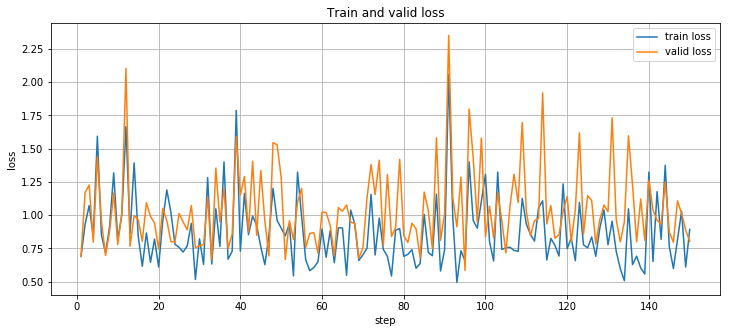

In [28]:
train_model_img_classification(model, lr_config, b1data,"d.pkl")

### Accuracy after training

In [29]:
prediction = model.predict(test_in)
labels = test_bach[1].type('torch.LongTensor')
correct = torch.sum(torch.eq(prediction, labels)).float()
accuracy = float(correct/labels.shape[0])
accuracy

0.4819999933242798